# Transfer Learning

Transfer Learning leverages a pretrained model that is already extremely performant on general feature detection. Our work will be to re-train this model on our specific dataset and add the specialized knowledge needed to solve our task.

Since the model is already pre-trained we can expect that we will only need about 10% of the amount of data that would be needed to train a fresh model.


## Fine-tuning Pre-trained Models

Using a pre-trained model from [tf.keras.applictions](https://www.tensorflow.org/api_docs/python/tf/keras/applications) and fine-tuning it to our problem.

In [1]:
import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

2023-03-15 13:51:35.309248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# global variables
SEED = 42
BATCH_SIZE = 32
IMG_SHAPE = (224, 224)

In [3]:
# export helper functions from above into helper script
from helper import create_tensorboard_callback, create_checkpoint_callback, plot_accuracy_curves, combine_training_curves

2023-03-15 13:51:41.884412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:51:42.212551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:51:42.213319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-15 13:51:42.214741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow w

In [4]:
# get 10% dataset
# wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# set directories for 10% dataset
training_directory_10 = "../datasets/10_food_classes_10_percent/train/"
testing_directory_10 = "../datasets/10_food_classes_10_percent/test/"

training_data_10 = image_dataset_from_directory(training_directory_10,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

testing_data_10 = image_dataset_from_directory(testing_directory_10,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

# get class names
class_names_10 = training_data_10.class_names

len(class_names_10), class_names_10 

# Found 750 files belonging to 10 classes.
# Found 2500 files belonging to 10 classes.

# (10,
#  ['chicken_curry',
#   'chicken_wings',
#   'fried_rice',
#   'grilled_salmon',
#   'hamburger',
#   'ice_cream',
#   'pizza',
#   'ramen',
#   'steak',
#   'sushi'])

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


(10,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [4]:
# inspect first image batch
## BatchDataset returns the image data matrices + 1-hot-encoded label matrix
for images, labels in training_data_10.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.10000000e+02 6.32397957e+01 0.00000000e+00]
   [1.18780609e+02 7.49744949e+01 7.37755108e+00]
   [1.06168365e+02 6.54438782e+01 1.02551079e+00]
   ...
   [9.51429443e+01 5.70000000e+01 2.21426392e+00]
   [1.04714348e+02 6.15000267e+01 8.57146740e+00]
   [1.10357109e+02 6.33571091e+01 9.35710812e+00]]

  [[1.14693878e+02 7.08877563e+01 4.36224604e+00]
   [1.14423470e+02 7.30051041e+01 7.14285660e+00]
   [1.10346939e+02 7.12346954e+01 6.29081631e+00]
   ...
   [9.44694366e+01 5.59285736e+01 1.34179497e+00]
   [1.00285751e+02 5.70714264e+01 4.14286995e+00]
   [1.07311264e+02 5.74490089e+01 4.40309334e+00]]

  [[1.07239792e+02 6.82346954e+01 7.65306503e-02]
   [1.13382652e+02 7.48112259e+01 7.59694004e+00]
   [1.13469383e+02 7.48520432e+01 9.94387722e+00]
   ...
   [9.81888351e+01 5.96173630e+01 5.04589176e+00]
   [1.02857155e+02 5.68571548e+01 4.85715580e+00]
   [1.09576607e+02 5.95766068e+01 6.57660770e+00]]

  ...

  [[9.08060455e+01 6.93775177e+01 2.37751961e+00]
   [9

1. Start by using [EfficientNetV2B0](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B0) as a __Feature Extractor__ (all layers frozen, ImageNet pretrained and without top).
2. Find a good sample size to optimize training (data augmentation).
3. Unfreeze layers from the pre-trained model and run fine-tuning (top 10 layers unfrozen).

| Experiment | Data | Pre-processing | Model |
| -- |-- |-- | -- |
| Model 0 | 10% Dataset | None | Feature Extraction: EfficientNetB0 |
| Model 1 | 1% Dataset | Augmented | same as Model 0 |
| Model 2 | same as Model 0 | same as Model 1 | same as Model 0 |
| Model 3 | same as Model 0 | same as Model 1 | Fine-tuning: EfficientNetB0 |
| Model 4 | 100% Dataset | same as Model 1 | same as Model 3 |


![Transfer Learning](../assets/04_Keras_Sequential_vs_Functional_API.png)

### Model 0

Using 10% of the training data and extract feature vectors using EfficientNetB0 from Keras Applications.

In [9]:
# build a model from tf.keras.applications
# using the keras functional API

# get base model from keras applications
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False
)

# freeze all layers (don't update pre-learned pattern)
base_model.trainable = False

# create input layer
input_layer = tf.keras.layers.Input(shape=IMG_SHAPE+(3,), name='input_layer')

# start by normalizing your data (not necessary for efficientnet)
# data = tf.keras.layers.Rescaling(1./255)(input_layer)

# pass (normalized) inputs to base model
data = base_model(input_layer)
print(f"INFO :: Input Shape: {data.shape}")
# INFO :: Input Shape: (None, 7, 7, 1280)

# average pool outputs of the base model
data = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(data)
print(f"INFO :: Feature Vector Shape: {data.shape}")
# INFO :: Feature Vector Shape: (None, 1280)

# create output layer
output_layer = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(data)

# build the model 0
model_0 = tf.keras.Model(input_layer, output_layer)

# compile model 0
model_0.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

INFO :: Input Shape: (None, 7, 7, 1280)
INFO :: Pooled Shape: (None, 1280)


In [14]:
# check model_0
model_0.summary()
# Model: "model_2"
# _________________________________________________________________
#  Layer (type)                Output Shape              Param #   
# =================================================================
#  input_layer (InputLayer)    [(None, 224, 224, 3)]     0
#  efficientnetb0 (Functional)  (None, None, None, 1280) 4049571
#  global_average_pooling_laye  (None, 1280)             0         
#  r (GlobalAveragePooling2D)
#  output_layer (Dense)        (None, 10)                12810
# =================================================================
# Total params: 4,062,381
# Trainable params: 12,810
# Non-trainable params: 4,049,571
# _________________________________________________________________

# check base_model layers
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)
    
# 0 input_5
# 1 rescaling_5
# 2 normalization_2
# 3 rescaling_6
# 4 stem_conv_pad
# 5 stem_conv
# 6 stem_bn
# 7 stem_activation
# 8 block1a_dwconv
# ...
# 234 block7a_project_bn
# 235 top_conv
# 236 top_bn
# 237 top_activation

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________
0 input_5
1 rescaling_5
2 normalization_2
3 rescaling_6
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activatio

In [10]:
# fit model 0
history_model_0 = model_0.fit(
                                training_data_10,
                                epochs=5,
                                steps_per_epoch=len(training_data_10),
                                validation_data=testing_data_10,
                                # speed up validation by skipping 75%
                                validation_steps=int(0.25 * len(testing_data_10)),
                                callbacks=[create_tensorboard_callback(
                                            '../tensorboard/transfer_learning',
                                            '10_percent_feature_extraction')
                                          ])

# Epoch 5/5
# 6s 267ms/step - loss: 0.5430 - accuracy: 0.8773 - val_loss: 0.5211 - val_accuracy: 0.8799

Saving TensorBoard Log to: ../tensorboard/transfer_learning/10_percent_feature_extraction/20230312-163402
Epoch 1/5


2023-03-12 16:34:07.575654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-12 16:34:09.805088: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-12 16:34:11.563576: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5655328de1f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-12 16:34:11.563628: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-12 16:34:11.595432: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-12 16:34:11.603382: I tensorflow/core/common_runtime/p

24/24 [==============================] - 31s 955ms/step - loss: 1.8838 - accuracy: 0.4280 - val_loss: 1.2528 - val_accuracy: 0.7566
Epoch 2/5
24/24 [==============================] - 6s 268ms/step - loss: 1.0894 - accuracy: 0.7680 - val_loss: 0.8127 - val_accuracy: 0.8553
Epoch 3/5
24/24 [==============================] - 6s 267ms/step - loss: 0.7865 - accuracy: 0.8200 - val_loss: 0.6218 - val_accuracy: 0.8898
Epoch 4/5
24/24 [==============================] - 6s 274ms/step - loss: 0.6396 - accuracy: 0.8533 - val_loss: 0.5635 - val_accuracy: 0.8882
Epoch 5/5
24/24 [==============================] - 6s 267ms/step - loss: 0.5430 - accuracy: 0.8773 - val_loss: 0.5211 - val_accuracy: 0.8799


### Model 0

Same as above but using the EfficientNet v2 B0 model.

In [7]:
base_model_2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# run in inference mode so batchnorm statistics don't get updated
# even after unfreezing the base model for fine-tuning
base_model_2.trainable = False

input_layer_2 = tf.keras.layers.Input(shape=IMG_SHAPE+(3,), name='input_layer')
# run in inference mode so batchnorm statistics don't get updated
# even after unfreezing the base model for fine-tuning
data_2 = base_model_2(input_layer_2, training=False)
data_2 = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(data_2)
output_layer_2 = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(data_2)

model_0_2 = tf.keras.Model(input_layer_2, output_layer_2)

model_0_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [8]:
# fit model 0
history_model_0_2 = model_0_2.fit(
                                training_data_10,
                                epochs=5,
                                steps_per_epoch=len(training_data_10),
                                validation_data=testing_data_10,
                                # speed up validation by skipping 75%
                                validation_steps=int(0.25 * len(testing_data_10)),
                                callbacks=[create_tensorboard_callback(
                                            '../tensorboard/transfer_learning',
                                            '10_percent_feature_extraction_model_2')
                                          ])

# Epoch 5/5
# 5s 222ms/step - loss: 0.6073 - accuracy: 0.8707 - val_loss: 0.5628 - val_accuracy: 0.8536

Saving TensorBoard Log to: ../tensorboard/transfer_learning/10_percent_feature_extraction_model_2/20230312-172936
Epoch 1/5


2023-03-12 17:29:40.238500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/efficientnetv2-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-12 17:29:41.091650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-03-12 17:29:42.031836: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x556c6d09b3a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-12 17:29:42.031857: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2023-03-12 17:29:42.036696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-12 17:29:42.037082: I tensorflow/core/common_runtime/

24/24 [==============================] - 14s 348ms/step - loss: 1.9555 - accuracy: 0.3733 - val_loss: 1.3486 - val_accuracy: 0.7171
Epoch 2/5
24/24 [==============================] - 6s 232ms/step - loss: 1.1783 - accuracy: 0.7333 - val_loss: 0.9098 - val_accuracy: 0.7977
Epoch 3/5
24/24 [==============================] - 5s 230ms/step - loss: 0.8625 - accuracy: 0.8147 - val_loss: 0.6895 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 6s 238ms/step - loss: 0.6995 - accuracy: 0.8413 - val_loss: 0.6154 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 5s 222ms/step - loss: 0.6073 - accuracy: 0.8707 - val_loss: 0.5628 - val_accuracy: 0.8536


### Model 1

Before I used 10% of the training dataset. Let's try using only 1% while leveraging Tensorflows augmentation functions to add variations to our dataset.

The idea is to find the absolut minimum of 'effort' with a small dataset and a light-weight base model to get started with. Experiment with this setup that gives you fast results. And once it is working reasonably well add more training data as well as model complexity to find the maximum in prediction accuracy.

In [12]:
# get 1% dataset
# wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

# set directories for 1% dataset
training_directory_1 = "../datasets/10_food_classes_1_percent/train/"
testing_directory_1 = "../datasets/10_food_classes_1_percent/test/"

training_data_1 = image_dataset_from_directory(training_directory_1,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

testing_data_1 = image_dataset_from_directory(testing_directory_1,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

# get class names
class_names_1 = training_data_1.class_names

len(class_names_1), class_names_1 

# Found 70 files belonging to 10 classes.
# Found 2500 files belonging to 10 classes.

# (10,
#  ['chicken_curry',
#   'chicken_wings',
#   'fried_rice',
#   'grilled_salmon',
#   'hamburger',
#   'ice_cream',
#   'pizza',
#   'ramen',
#   'steak',
#   'sushi'])

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


(10,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

#### Add Augmentation Layer

In [5]:
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    # tf.keras.layers.Rescaling(1./255) # not needed for EfficientNet
], name="data_augmentation_layer")

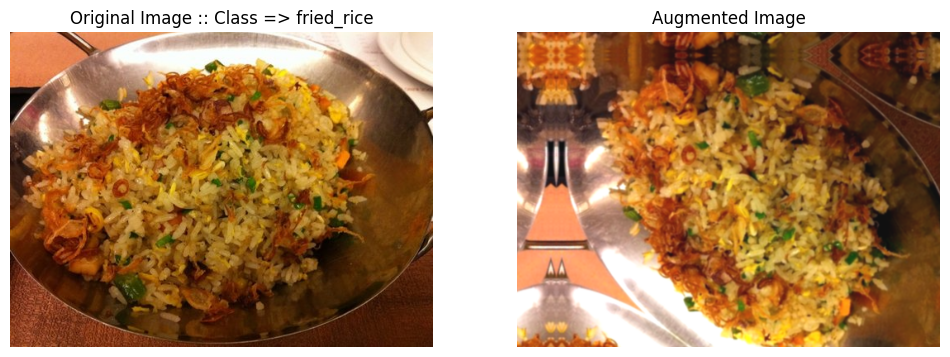

In [66]:
# visualize augmentations
## pick random image from training set
target_class = random.choice(class_names_1)
target_dir = training_directory_1 + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
img = mpimg.imread(random_image_path)

# run image through aug layer
augmented_img = data_augmentation_layer(img, training=True)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
plt.title(f"Original Image :: Class => {target_class}")
plt.axis(False)
plt.imshow(img)
plt.subplot(2, 2, 2)
plt.title("Augmented Image")
plt.axis(False)
plt.imshow(augmented_img/255)

![Tensorflow Transfer Learning](../assets/04_Tensorflow_Transfer_Learning_07.png)

In [67]:
# build model 1
base_model1 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model1.trainable = False

input_layer1 = tf.keras.layers.Input(shape=IMG_SHAPE+(3,), name='input_layer')
data1 = data_augmentation_layer(input_layer1)
# run in inference mode so batchnorm statistics don't get updated
# even after unfreezing the base model for fine-tuning
data1 = base_model1(data1, training=False)
data1 = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(data1)
output_layer1 = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(data1)

model_1 = tf.keras.Model(input_layer1, output_layer1)

model_1.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

In [68]:
# fit model 1
history_model_1 = model_1.fit(
                                training_data_1,
                                epochs=5,
                                steps_per_epoch=len(training_data_1),
                                validation_data=testing_data_1,
                                # speed up validation by skipping 75%
                                validation_steps=int(0.25 * len(testing_data_1)),
                                callbacks=[create_tensorboard_callback(
                                            '../tensorboard/transfer_learning',
                                            '1_percent_feature_extraction_model')
                                          ])

# Epoch 5/5
# 4s 2s/step - loss: 1.7357 - accuracy: 0.5286 - val_loss: 1.9652 - val_accuracy: 0.3372

# even with only 1% of the data there is still a 34% accuracy over ten
# classes - while the original paper achieved ~50% over 101 classes
# https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Saving TensorBoard Log to: ../tensorboard/transfer_learning/1_percent_feature_extraction_model/20230312-190149
Epoch 1/5
3/3 [==============================] - 25s 8s/step - loss: 2.3805 - accuracy: 0.1286 - val_loss: 2.2770 - val_accuracy: 0.1464
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1290 - accuracy: 0.2714 - val_loss: 2.1692 - val_accuracy: 0.2122
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9726 - accuracy: 0.3857 - val_loss: 2.0837 - val_accuracy: 0.2944
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8358 - accuracy: 0.5000 - val_loss: 2.0353 - val_accuracy: 0.2944
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.7357 - accuracy: 0.5286 - val_loss: 1.9652 - val_accuracy: 0.3372


### Model 2

Let's try the augmentation layer on 10% of the dataset - so the same as model 0 but with added augmentations.

In [8]:
base_model2 = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
# run in inference mode so batchnorm statistics don't get updated
# even after unfreezing the base model for fine-tuning
base_model2.trainable = False

input_layer2 = tf.keras.layers.Input(shape=IMG_SHAPE+(3,), name='input_layer')
data2 = data_augmentation_layer(input_layer2)
# run in inference mode so batchnorm statistics don't get updated
# even after unfreezing the base model for fine-tuning
data2 = base_model2(data2, training=False)
data2 = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(data2)
output_layer2 = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(data2)

model_2 = tf.keras.Model(input_layer2, output_layer2)

model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(),
               metrics=['accuracy'])

### Adding ModelCheckpoint Callback

Added to `helper.py`:
    
```py
# create a training checkpoint callback
def create_checkpoint_callback(dir_name, experiment_name):
    # log progress to log directory
    filepath = dir_name + "/" + experiment_name
    tf.keras.callbacks.ModelCheckpoint(
        filepath=filepath, monitor='val_accuracy', verbose=0, save_best_only=True,
        save_weights_only=True, save_freq='epoch')
    print(f"Saving Checkpoint to: {filepath}")
    return checkpoint_callback
```


In [9]:
# fit model 2
# training epochs before fine-tuning
pretraining_epochs = 5

history_model_2 = model_2.fit(
                                training_data_10,
                                epochs=pretraining_epochs,
                                steps_per_epoch=len(training_data_10),
                                validation_data=testing_data_10,
                                validation_steps=len(testing_data_10),
                                callbacks=[create_tensorboard_callback(
                                            '../tensorboard/transfer_learning',
                                            '10_percent_feature_extraction_model_augmented'),
                                           create_checkpoint_callback('../checkpoints/transfer_learning',
                                            '10_percent_feature_extraction_model_augmented')
                                          ])

# Epoch 5/5
# 15s 634ms/step - loss: 0.9873 - accuracy: 0.7307 - val_loss: 0.8316 - val_accuracy: 0.7724
# INFO :: Saving TensorBoard Log to: ../tensorboard/transfer_learning/10_percent_feature_extraction_model_augmented/20230315-135701
# INFO :: Saving Checkpoint to: ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented

INFO :: Saving TensorBoard Log to: ../tensorboard/transfer_learning/10_percent_feature_extraction_model_augmented/20230315-135701
INFO :: Saving Checkpoint to: ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented
Epoch 1/5
24/24 [==============================] - 27s 686ms/step - loss: 2.0893 - accuracy: 0.2693 - val_loss: 1.6771 - val_accuracy: 0.5452
Epoch 2/5
24/24 [==============================] - 15s 639ms/step - loss: 1.5138 - accuracy: 0.5853 - val_loss: 1.2932 - val_accuracy: 0.6564
Epoch 3/5
24/24 [==============================] - 15s 642ms/step - loss: 1.2471 - accuracy: 0.6747 - val_loss: 1.0681 - val_accuracy: 0.7236
Epoch 4/5
24/24 [==============================] - 15s 642ms/step - loss: 1.0822 - accuracy: 0.7133 - val_loss: 0.9256 - val_accuracy: 0.7540
Epoch 5/5
24/24 [==============================] - 15s 634ms/step - loss: 0.9873 - accuracy: 0.7307 - val_loss: 0.8316 - val_accuracy: 0.7724


### Restoring Model from Checkpoint

The __ModelCheckpoint__ callback allows us to return a compiled model back to a past state by loading the saved weights that were generated by a previous training.

In [8]:
# check current validation metrics
model_2_validation_metric_5_epochs = model_2.evaluate(testing_data_10)
print(model_2_validation_metric_5_epochs)

# 79/79 [==============================] - 6s 73ms/step - loss: 0.8056 - accuracy: 0.7972
# [0.805601179599762, 0.7972000241279602]

79/79 [==============================] - 6s 73ms/step - loss: 0.8056 - accuracy: 0.7972
[0.805601179599762, 0.7972000241279602]


In [8]:
# load latest checkpoint and "restore" weights
checkpoint_path = '../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented/20230312-201041'
model_2.load_weights(checkpoint_path)

# check validation metrics from loaded weights
model_2_validation_metric_5_epochs_loaded = model_2.evaluate(testing_data_10)
print(model_2_validation_metric_5_epochs_loaded)

# 79/79 [==============================] - 6s 74ms/step - loss: 0.6724 - accuracy: 0.8320
# [0.6724268794059753, 0.8320000171661377]

2023-03-15 11:26:08.051256: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented/20230312-201041: FAILED_PRECONDITION: ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented/20230312-201041; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


79/79 [==============================] - 6s 76ms/step - loss: 0.6724 - accuracy: 0.8320
[0.6724267601966858, 0.8320000171661377]


## Model Fine-tuning

1. Freeze the imported model and find best parameters to use it for your prediction problem (as done above).
2. Train the model with found parameters on a large dataset from your porediction problem.
3. Unfreeze "some" of the layers of the imported model and re-run the training to fine-tune your model.

In [9]:
# layers in the trained model
model_2.layers

# [<keras.engine.input_layer.InputLayer at 0x7faa5f7b3df0>,
#  <keras.engine.sequential.Sequential at 0x7faa5f7b2380>,
#  <keras.engine.functional.Functional at 0x7faa3ffaf4f0>,
#  <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D at 0x7fa9d069fb80>,
#  <keras.layers.core.dense.Dense at 0x7fa9d07c0eb0>]

In [12]:
# trainable layers in model

for layer in model_2.layers:
    print(layer, layer.trainable)
    
# <keras.engine.input_layer.InputLayer object at 0x7faa5f7b3df0> True
# <keras.engine.sequential.Sequential object at 0x7faa5f7b2380> True
# <keras.engine.functional.Functional object at 0x7faa3ffaf4f0> False
# <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa9d069fb80> True
# <keras.layers.core.dense.Dense object at 0x7fa9d07c0eb0> True

<keras.engine.input_layer.InputLayer object at 0x7faa5f7b3df0> True
<keras.engine.sequential.Sequential object at 0x7faa5f7b2380> True
<keras.engine.functional.Functional object at 0x7faa3ffaf4f0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa9d069fb80> True
<keras.layers.core.dense.Dense object at 0x7fa9d07c0eb0> True


In [13]:
# layer 2 is the frozen imported model (efficientnetb0)
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)
    
# 0 input_1 False
# 1 rescaling False
# 2 normalization False
# 3 stem_conv False
# 4 stem_bn False
# 5 stem_activation False
# ...
# 257 block6h_activation False
# 258 block6h_se_squeeze False
# 259 block6h_se_reshape False
# 260 block6h_se_reduce False
# 261 block6h_se_expand False
# 262 block6h_se_excite False
# 263 block6h_project_conv False
# 264 block6h_project_bn False
# 265 block6h_drop False
# 266 block6h_add False
# 267 top_conv False
# 268 top_bn False
# 269 top_activation False

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [14]:
# the entire model is frozen for now
print(len(model_2.layers[2].trainable_variables))
# 0

0


In [10]:
# make last 10 layers trainable
## unfreeze ALL layers
base_model2.trainable = True

## re-freeze ALL BUT the last 10 layers
for layer in base_model2.layers[:-10]:
    layer.trainable = False

In [21]:
# we now have 10 trainable layers
print(len(model_2.layers[2].trainable_variables))
# 10

for layer in base_model2.layers[-10:]:
    print(layer.name, layer.trainable)
# block6h_se_reduce True
# block6h_se_expand True
# block6h_se_excite True
# block6h_project_conv True
# block6h_project_bn True
# block6h_drop True
# block6h_add True
# top_conv True
# top_bn True
# top_activation True

10
block6h_se_reduce True
block6h_se_expand True
block6h_se_excite True
block6h_project_conv True
block6h_project_bn True
block6h_drop True
block6h_add True
top_conv True
top_bn True
top_activation True


In [11]:
# recompile the model with the new basemodel
# to prevent overfitting / to better hold on to pre-training
# the learning rate during fine-tuning should be lowered 10x
# default Adam(lr)=1e-3 => 1e-4
model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics=['accuracy'])

In [25]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)
    
# the model is now compiled with the 10 new trainable layers from base_model (efficientnetb0)
# 0 input_1 False
# 1 rescaling False
# 2 normalization False
# 3 stem_conv False
# 4 stem_bn False
# 5 stem_activation False
# ...
# 257 block6h_activation False
# 258 block6h_se_squeeze False
# 259 block6h_se_reshape False
# 260 block6h_se_reduce True
# 261 block6h_se_expand True
# 262 block6h_se_excite True
# 263 block6h_project_conv True
# 264 block6h_project_bn True
# 265 block6h_drop True
# 266 block6h_add True
# 267 top_conv True
# 268 top_bn True
# 269 top_activation True

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

### Re-Run the Training

In [12]:
# fit model 2
fine_tuning_epochs = pretraining_epochs + 5

fine_tuning_model_2 = model_2.fit(
                    training_data_10,
                    epochs = fine_tuning_epochs,
                    # start from last pre-training checkpoint
                    # training from epoch 6 - 10
                    initial_epoch = history_model_2.epoch[-1],
                    steps_per_epoch = len(training_data_10),
                    validation_data = testing_data_10,
                    validation_steps = len(testing_data_10),
                    callbacks = [create_tensorboard_callback(
                                '../tensorboard/transfer_learning',
                                '10_percent_feature_extraction_model_augmented_finetuning'),
                               create_checkpoint_callback('../checkpoints/transfer_learning',
                                '10_percent_feature_extraction_model_augmented_finetuning')
                              ])

# Epoch 10/10
# 15s 640ms/step - loss: 0.5083 - accuracy: 0.8480 - val_loss: 0.4590 - val_accuracy: 0.8432
# INFO :: Saving Checkpoint to: ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented_finetuning

INFO :: Saving TensorBoard Log to: ../tensorboard/transfer_learning/10_percent_feature_extraction_model_augmented_finetuning/20230315-135930
INFO :: Saving Checkpoint to: ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented_finetuning
Epoch 5/10
24/24 [==============================] - 28s 707ms/step - loss: 0.7983 - accuracy: 0.7853 - val_loss: 0.6100 - val_accuracy: 0.8136
Epoch 6/10
24/24 [==============================] - 15s 643ms/step - loss: 0.6705 - accuracy: 0.7987 - val_loss: 0.5492 - val_accuracy: 0.8192
Epoch 7/10
24/24 [==============================] - 15s 633ms/step - loss: 0.6127 - accuracy: 0.7987 - val_loss: 0.4989 - val_accuracy: 0.8352
Epoch 8/10
24/24 [==============================] - 15s 641ms/step - loss: 0.5292 - accuracy: 0.8387 - val_loss: 0.4949 - val_accuracy: 0.8336
Epoch 9/10
24/24 [==============================] - 15s 652ms/step - loss: 0.5053 - accuracy: 0.8440 - val_loss: 0.4686 - val_accuracy: 0.8376
Epoch 10/10
24/24 [=====

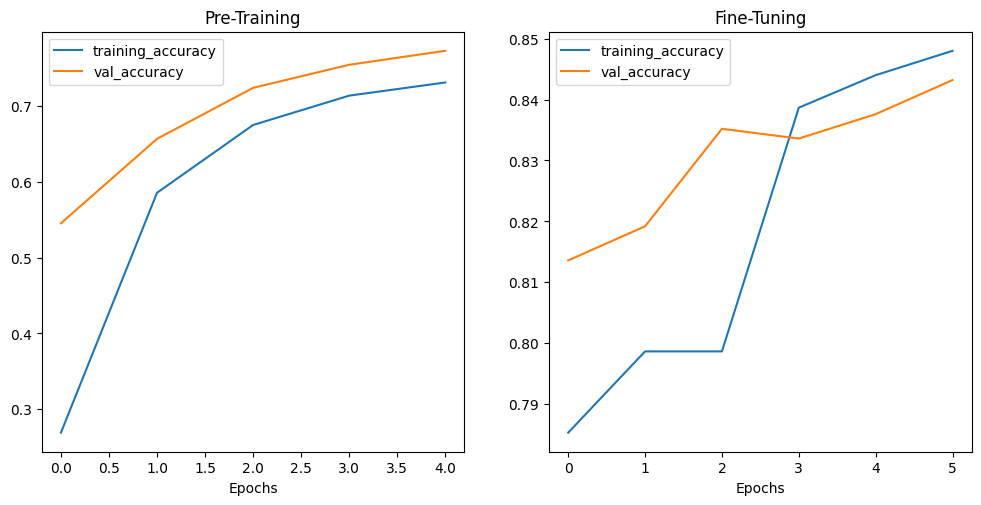

In [13]:
plot_accuracy_curves(history_model_2, "Pre-Training", fine_tuning_model_2, "Fine-Tuning")

![Fine-tuning Pre-trained Models](../assets/04_Tensorflow_Transfer_Learning_08.png)

Added helper function to `helper.py`:
    
```py
def combine_training_curves(original_history, new_history, pretraining_epochs):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([pretraining_epochs-1, pretraining_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([pretraining_epochs-1, pretraining_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
```

5
11
[0.2693333327770233, 0.5853333473205566, 0.6746666431427002, 0.7133333086967468, 0.7306666374206543, 0.7853333353996277, 0.7986666560173035, 0.7986666560173035, 0.8386666774749756, 0.843999981880188, 0.8479999899864197]


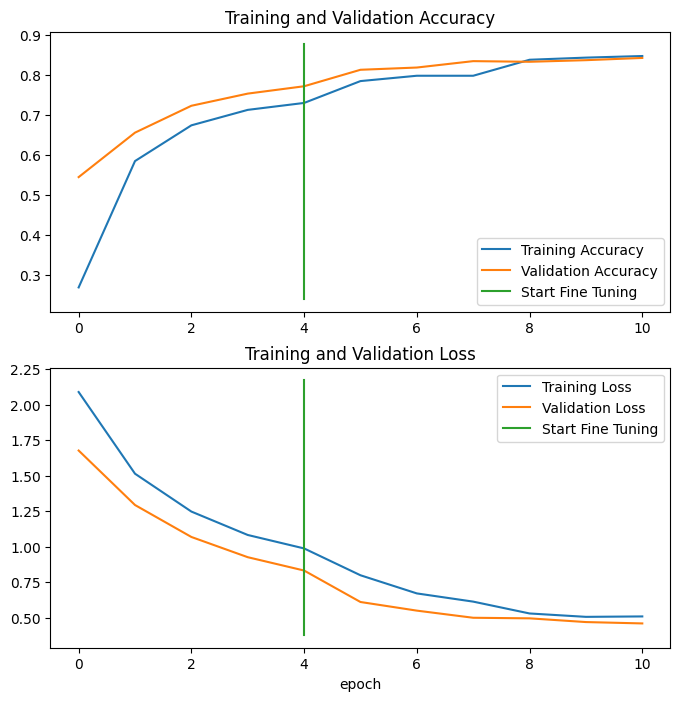

In [14]:
combine_training_curves(history_model_2, fine_tuning_model_2, pretraining_epochs=5)

# 5
# 11
# [0.2879999876022339, 0.6066666841506958, 0.671999990940094, 0.7293333411216736, 0.7639999985694885, 0.7879999876022339, 0.8173333406448364, 0.8199999928474426, 0.8053333163261414, 0.8346666693687439, 0.8413333296775818]

# The fine-tuning works - accuracy keeps going up during the tuning epochs:

![Fine-tuning Pre-trained Models](../assets/04_Tensorflow_Transfer_Learning_09.png)

## Final Training

1. Finding parameters to train simple pre-trained models with small datasets.
2. Find the right amount of layers to unfreeze for fine-tuning the pre-trained model.
3. Train the developed model with the found parameters on your whole dataset.

In [15]:
# get 100% dataset
# wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# set directories for 10% dataset
training_directory_100 = "../datasets/10_food_classes_all_data/train/"
testing_directory_100 = "../datasets/10_food_classes_all_data/test/"

training_data_100 = image_dataset_from_directory(training_directory_100,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

testing_data_100 = image_dataset_from_directory(testing_directory_100,
                                              labels='inferred',
                                              label_mode='categorical',
                                              seed=SEED,
                                              shuffle=True,
                                              image_size=IMG_SHAPE,
                                              batch_size=BATCH_SIZE)

# get class names
class_names_100 = training_data_100.class_names

len(class_names_100), class_names_100 

# Found 7500 files belonging to 10 classes.
# Found 2500 files belonging to 10 classes.

# (10,
#  ['chicken_curry',
#   'chicken_wings',
#   'fried_rice',
#   'grilled_salmon',
#   'hamburger',
#   'ice_cream',
#   'pizza',
#   'ramen',
#   'steak',
#   'sushi'])

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


(10,
 ['chicken_curry',
  'chicken_wings',
  'fried_rice',
  'grilled_salmon',
  'hamburger',
  'ice_cream',
  'pizza',
  'ramen',
  'steak',
  'sushi'])

In [23]:
# run the training

model_2.compile(loss='categorical_crossentropy',
               optimizer=tf.keras.optimizers.Adam(1e-4),
               metrics=['accuracy'])

final_training_epochs = fine_tuning_epochs + 5

history_model_2_full = model_2.fit(
                    training_data_100,
                    epochs = final_training_epochs,
                    # start from last fine tuning checkpoint
                    # training from epoch 11 - 15
                    initial_epoch = fine_tuning_model_2.epoch[-1],
                    steps_per_epoch = len(training_data_100),
                    validation_data = testing_data_100,
                    validation_steps = int(0.25 * len(testing_data_100)),
                    callbacks = [create_tensorboard_callback(
                                '../tensorboard/transfer_learning',
                                '100_percent_feature_extraction_model'),
                               create_checkpoint_callback('../checkpoints/transfer_learning',
                                '100_percent_feature_extraction_model')
                              ])

# Epoch 15/15
# 70s 299ms/step - loss: 0.5249 - accuracy: 0.8344 - val_loss: 0.3030 - val_accuracy: 0.9013
# INFO :: Saving Checkpoint to: ../checkpoints/transfer_learning/10_percent_feature_extraction_model_augmented_finetuning

INFO :: Saving TensorBoard Log to: ../tensorboard/transfer_learning/100_percent_feature_extraction_model/20230315-143612
INFO :: Saving Checkpoint to: ../checkpoints/transfer_learning/100_percent_feature_extraction_model
Epoch 10/15
235/235 [==============================] - 84s 313ms/step - loss: 0.7159 - accuracy: 0.7711 - val_loss: 0.3226 - val_accuracy: 0.8947
Epoch 11/15
235/235 [==============================] - 74s 315ms/step - loss: 0.6500 - accuracy: 0.7999 - val_loss: 0.2729 - val_accuracy: 0.9145
Epoch 12/15
235/235 [==============================] - 73s 312ms/step - loss: 0.6089 - accuracy: 0.8009 - val_loss: 0.3011 - val_accuracy: 0.8964
Epoch 13/15
235/235 [==============================] - 68s 288ms/step - loss: 0.5734 - accuracy: 0.8153 - val_loss: 0.2994 - val_accuracy: 0.8964
Epoch 14/15
235/235 [==============================] - 67s 287ms/step - loss: 0.5391 - accuracy: 0.8275 - val_loss: 0.3059 - val_accuracy: 0.8914
Epoch 15/15
235/235 [============================

In [24]:
print(model_2.evaluate(testing_data_100))
# 21s 266ms/step - loss: 0.3093 - accuracy: 0.8972
# [0.3092549443244934, 0.8971999883651733]

79/79 [==============================] - 21s 266ms/step - loss: 0.3093 - accuracy: 0.8972
[0.3092549443244934, 0.8971999883651733]


6
12
[0.7853333353996277, 0.7986666560173035, 0.7986666560173035, 0.8386666774749756, 0.843999981880188, 0.8479999899864197, 0.7710666656494141, 0.7998666763305664, 0.8009333610534668, 0.8153333067893982, 0.8274666666984558, 0.8343999981880188]


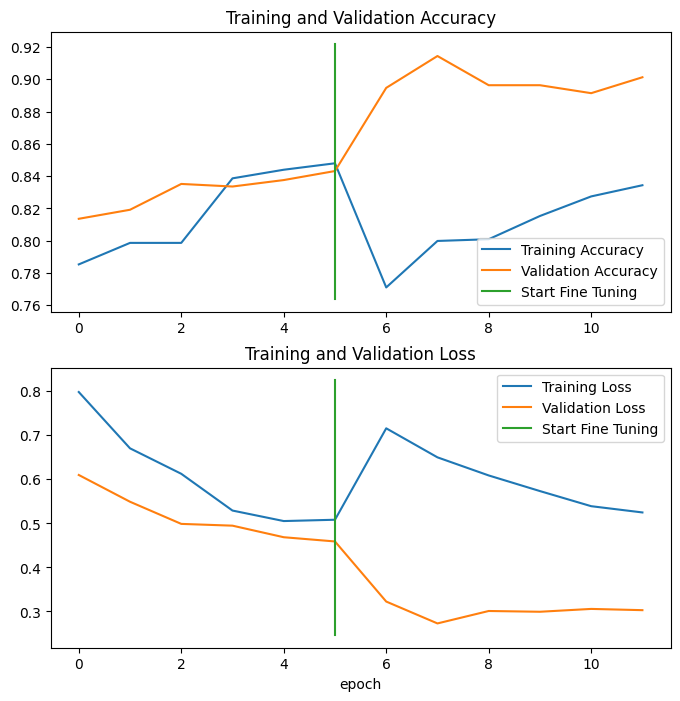

In [26]:
combine_training_curves(fine_tuning_model_2, history_model_2_full, pretraining_epochs=6)

![Fine-tuning Pre-trained Models](../assets/04_Tensorflow_Transfer_Learning_10.png)

In [27]:
# Load TensorBoard
%load_ext tensorboard
%tensorboard --logdir '../tensorboard/'

![Fine-tuning Pre-trained Models](../assets/04_Tensorflow_Transfer_Learning_11.png)

![Fine-tuning Pre-trained Models](../assets/04_Tensorflow_Transfer_Learning_12.png)